### Look at Performance of the refitted Models
---

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu
import pickle as pkl

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("../../artifacts/refitting-202021Q1/customer_risk_20201130_w_ind.pkl", "rb") as f:
    clf_w_ind = pkl.load(f)
with open("../../artifacts/refitting-202021Q1/customer_risk_20201130_wo_ind.pkl", "rb") as f:
    clf_wo_ind = pkl.load(f)
with open("../../artifacts/refitting-202021Q1/customer_risk_target_no_giact_time_since_last_link.pkl", "rb") as f:
    prev_model = pkl.load(f)

In [3]:
clf_w_ind, clf_wo_ind, prev_model

(LGBMClassifier(bagging_seed=15556, boosting='gbdt',
                categorical_feature=[39, 40, 41], feature_fraction=0.8,
                lambda_l1=16, lambda_l2=10, learning_rate=0.03, max_depth=4,
                metric='auc', min_data_in_leaf=116, num_iterations=1400,
                num_leaves=15, objective='binary',
                scale_pos_weight=29.051314094798453, seed=15556, subsample=0.94,
                tree_learner='feature', verbosity=1),
 LGBMClassifier(bagging_seed=15556, boosting='gbdt',
                categorical_feature=[39, 40, 41], feature_fraction=0.8,
                lambda_l1=16, lambda_l2=10, learning_rate=0.03, max_depth=4,
                metric='auc', min_data_in_leaf=116, num_iterations=1400,
                num_leaves=15, objective='binary',
                scale_pos_weight=190.47879626930924, seed=15556, subsample=0.94,
                tree_learner='feature', verbosity=1),
 LGBMClassifier(bagging_seed=15556, boosting='gbdt',
                categoric

In [ ]:
mmonth = "202104"
s3_base_path = f"s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/monitor/{mmonth}"
train_df = pd.read_parquet(os.path.join(s3_base_path, "dev_train_20201201_scored.parquet"))
test_df = pd.read_parquet(os.path.join(s3_base_path, "dev_test_20201201_scored.parquet"))

In [ ]:
pred_cols = ['score_20191231', 
             'score_20201130_wo_ind', 
             'score_20201130_w_ind']

In [ ]:
report = mntr.get_pred_reports(test_df, "target", pred_cols, dropna=True)
report

,auc,ap,ks
score_20191231,74.70,16.18,32.52
score_20201130_wo_ind,52.23,1.99,7.37
score_20201130_w_ind,92.26,42.31,69.52


In [ ]:
test_df_ = mu.prep_customer_data(test_df)
pred_cols = ['fico_adjusted_pred',
             'fraud_score_2',
             'pred_20191231', 
             'pred_20201130_w_ind']
report = mntr.get_pred_reports(test_df_, "target", pred_cols, dropna=True)
report.index = ["fico_adjusted_pred", 
                "fraud_score_2", 
                "incumbent_model",
                "refitted_model"]
report

,auc,ap,ks
fico_adjusted_pred,65.34,1.69,26.15
fraud_score_2,70.46,2.85,33.20
incumbent_model,74.70,16.18,32.52
refitted_model,92.26,42.31,69.52


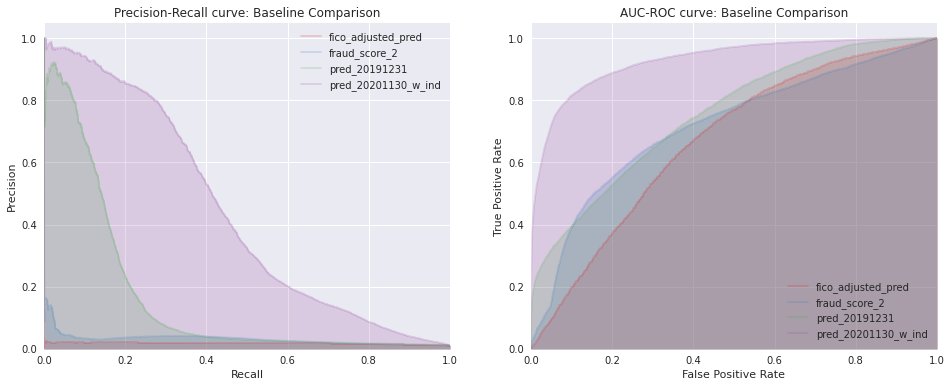

In [ ]:
mntr_path = "./artifacts"
df_ = test_df[(test_df.fico_score.between(300, 850))
              & (~test_df.fraud_score_2.isna())]
mntr.save_valid_performance_plots(
        {"20201201": df_}, "target", pred_cols, mntr_path, dropna=True
    )

### Active
---

* historically thomas saw: (df_dev.nr_past_transactions > 0) & (df_dev.nr_transactions_30d > 0)

In [ ]:
test_df["is_active"] = (test_df.nr_past_transactions > 0) & (test_df.nr_transactions_30d > 0)
df_ = test_df[test_df.is_active]

In [ ]:
report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
report

,auc,ap,ks
fico_adjusted_pred,77.93,7.67,46.37
fraud_score_2,75.83,8.78,42.20
pred_20191231,91.10,34.90,65.36
pred_20201130_w_ind,94.91,56.37,75.23


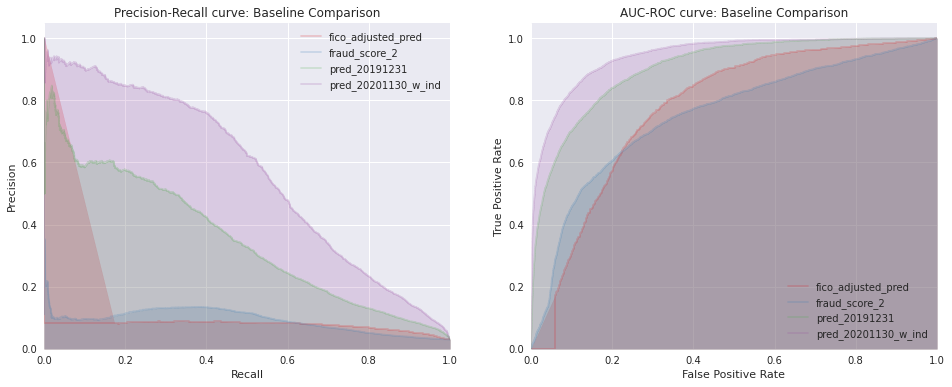

In [ ]:
mntr_path = "./artifacts"
mntr.save_valid_performance_plots(
        {"20201201-active": df_}, "target", pred_cols, mntr_path, dropna=True
    )

### Inactive
---

In [ ]:
df_ = test_df[~test_df.is_active]

In [ ]:
report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
report

,auc,ap,ks
fico_adjusted_pred,63.48,1.11,22.89
fraud_score_2,68.67,2.00,30.48
pred_20191231,74.46,15.53,33.07
pred_20201130_w_ind,89.66,31.42,62.87


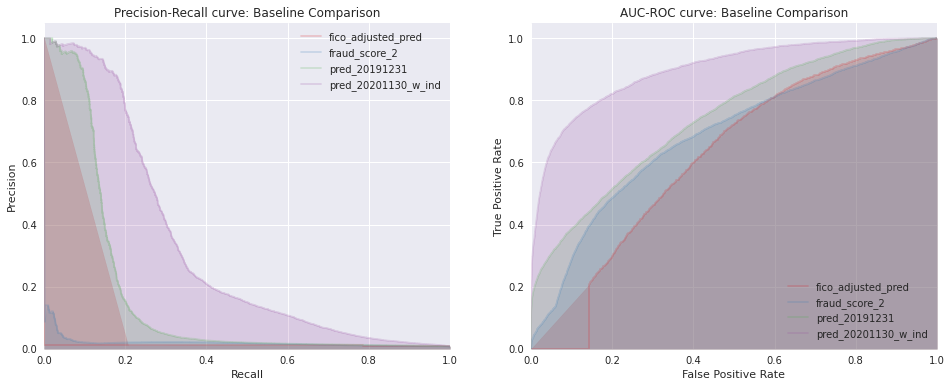

In [ ]:
mntr_path = "./artifacts"
mntr.save_valid_performance_plots(
        {"20201201-inactive": df_}, "target", pred_cols, mntr_path, dropna=True
    )

### Can we get some info from SHAP
---

If SHAP does not behave well, we may need to consider refit with monotonic constraint.

In [ ]:
clf_wo_ind.feature_name_

['first_deposit_amount',
 'vantage_score',
 'bcc7120',
 'email_risk_score',
 'fraud_score_2',
 'name_email_correlation',
 'transaction_as_pct_of_balance',
 'mean_account_balance_30d',
 'phone_risk_score',
 'name_address_correlation',
 'all8220',
 'lag_acc_open_first_transaction',
 'dollar_val_dd',
 'all7120',
 'sum_deposits_10d',
 'nr_past_transactions',
 'total_tradelines_open',
 'education_loan_amount',
 'address_risk_score',
 'iqt9415',
 'max_withdrawals_30d',
 'iln5520',
 'max_deposits_30d',
 'pct_returned_deposits',
 'giact_nr_decline',
 'nr_direct_deposits',
 'time_since_last_transaction',
 'bal_ratio',
 'name_phone_correlation',
 'giact_nr_other',
 'dollar_val_returns',
 'nr_trans_ratio',
 'iqt9413',
 'dollar_val_returns_3d',
 'nr_returns_30d',
 'credit_card_loan_amount',
 'fraud_score_1',
 'age_money_account',
 'transaction_code_encoded',
 'all7120_default_encoded',
 'bcc7120_default_encoded']

In [ ]:
clf_w_ind, clf_wo_ind, prev_model

(LGBMClassifier(bagging_seed=15556, boosting='gbdt',
                categorical_feature=[39, 40, 41], feature_fraction=0.8,
                lambda_l1=16, lambda_l2=10, learning_rate=0.03, max_depth=4,
                metric='auc', min_data_in_leaf=116, num_iterations=1400,
                num_leaves=15, objective='binary',
                scale_pos_weight=29.051314094798453, seed=15556, subsample=0.94,
                tree_learner='feature', verbosity=1),
 LGBMClassifier(bagging_seed=15556, boosting='gbdt',
                categorical_feature=[39, 40, 41], feature_fraction=0.8,
                lambda_l1=16, lambda_l2=10, learning_rate=0.03, max_depth=4,
                metric='auc', min_data_in_leaf=116, num_iterations=1400,
                num_leaves=15, objective='binary',
                scale_pos_weight=190.47879626930924, seed=15556, subsample=0.94,
                tree_learner='feature', verbosity=1),
 LGBMClassifier(bagging_seed=15556, boosting='gbdt',
                categoric

In [ ]:
import shap

df_sample = train_df.sample(n=int(1e6), random_state=42)

models = {"clf_w_ind": clf_w_ind,
          "clf_wo_ind": clf_wo_ind,
          "prev_model": prev_model}

In [ ]:
shaps = {}
for mname, mmodel in tqdm(models.items()):
    explainer = shap.TreeExplainer(mmodel)
    shap_values = explainer.shap_values(df_sample[mmodel.feature_name_])
    shaps[mname] = shap_values

 67%|██████▋   | 2/3 [01:42<00:50, 50.76s/it]

### Look at how models behave regarding ACTIVENESS
---
#### Two Features are associated with activeness
* time_since_last_transaction
* nr_past_transactions

In [ ]:
# prev model
mname = "prev_model"
mmodel = models[mname]
shap_ = shaps[mname][1]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
shap.dependence_plot("time_since_last_transaction", shap_, 
                     df_sample[mmodel.feature_name_], ax=ax[0], show=False,
                     interaction_index="nr_past_transactions")
shap.dependence_plot("nr_past_transactions", shap_, 
                     df_sample[mmodel.feature_name_], ax=ax[1], show=False,
                     interaction_index="time_since_last_transaction")
ax[0].set_xlim(0, 55)
ax[0].set_ylim(-0.5, 0.5)
ax[1].set_xlim(0, 400)
plt.title(mname)
plt.subplots_adjust(wspace=0.4)

In [ ]:
# clf_w_ind
mname = "clf_w_ind"
mmodel = models[mname]
shap_ = shaps[mname][1]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
shap.dependence_plot("time_since_last_transaction", shap_, 
                     df_sample[mmodel.feature_name_], ax=ax[0], show=False,
                     interaction_index="nr_past_transactions")
shap.dependence_plot("nr_past_transactions", shap_, 
                     df_sample[mmodel.feature_name_], ax=ax[1], show=False,
                     interaction_index="time_since_last_transaction")
ax[0].set_xlim(0, 55)
ax[0].set_ylim(-0.5, 0.5)
ax[1].set_xlim(0, 400)
plt.title(mname)
plt.subplots_adjust(wspace=0.4)

In [ ]:
# clf_wo_ind
mname = "clf_wo_ind"
mmodel = models[mname]
shap_ = shaps[mname][1]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
shap.dependence_plot("time_since_last_transaction", shap_, 
                     df_sample[mmodel.feature_name_], ax=ax[0], show=False,
                     interaction_index="nr_past_transactions")
shap.dependence_plot("nr_past_transactions", shap_, 
                     df_sample[mmodel.feature_name_], ax=ax[1], show=False,
                     interaction_index="time_since_last_transaction")
ax[0].set_xlim(0, 55)
ax[0].set_ylim(-0.5, 0.5)
ax[1].set_xlim(0, 400)
plt.title(mname)
plt.subplots_adjust(wspace=0.4)

looking at the shap plots, we can observe that there is a clear difference resulted from removing indeterminates, especially in the case that nr_past_transactions actually reverted its direction in terms of shap.

What is interesting is that by including indeterminate, nr_past_transactions have a negative trend, meaning more transactions lead to less risk, whereas with ind removed, model believes more nr_past_transactions leads to higher risk...

### How does the models treat ACTIVENESS differently?
---

* candidates: prev_model and clf_wo_ind
* The question to answer is: 
    * does the refitted model artificially boost model score, because many dormant accounts with positive labels would lift the performance.
* Maybe I need to plot segmented on activeness and the true label

In [ ]:
test_df["is_active"] = (test_df.nr_past_transactions > 0) & (test_df.nr_transactions_30d > 0)

#### Active + Target=True

In [ ]:
df_ = test_df[test_df.is_active 
              & test_df.target]
display(df_.shape)

score_col = "score_20191231"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_20201130_w_ind"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_rescaled_20201130_wo_ind"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

plt.legend()

With the rescaled score, the actively bad account's score got pushed up. But If we remove indeterminate, the scores reduced.

In [ ]:
df_ = test_df[~test_df.is_active 
              & test_df.target]
display(df_.shape)

score_col = "score_20191231"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_20201130_w_ind"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_rescaled_20201130_wo_ind"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

plt.legend()

Bad inactive account see their scores increased with rescalling. If we train with indeterminate...the distribution shift both to the left and right.

In [ ]:
df_ = test_df[test_df.is_active 
              & ~test_df.target]
display(df_.shape)

score_col = "score_20191231"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_20201130_w_ind"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_rescaled_20201130_wo_ind"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

plt.legend()

Much higher score for the refitted-rescaled model, for good active accounts. Don't know how to interpret this...Should we believe that active accounts have lower/higher risk????

I guess one purpose for this study is to confirm whether there is the existence of model not penalizing inactive accounts enough, so the distribution below that contains most data would make the difference.

In [ ]:
df_ = test_df[~test_df.is_active 
              & ~test_df.target]
display(df_.shape)

score_col = "score_20191231"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_20201130_w_ind"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_rescaled_20201130_wo_ind"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

plt.legend()

TRUE, inactive accounts were less penalized in the new score. How about from the probability distribution perspective?

In [ ]:
df_ = test_df[~test_df.is_active 
              & ~test_df.target]
display(df_.shape)

score_col = "pred_20191231"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "pred_20201130_w_ind"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "pred_20201130_wo_ind"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

plt.legend()

The model will still penalize in-activeness if we remove indeterminant.

### Conclusion
---

We have three constraints at the current point in time:
* We need good performance on the validation set to justify using the new model
* Model needs to perserve current user RGs as much as possible for better user experience.
* Model should not be too lenient with inactive accounts

With this observation, I think there are two potential ways to addresss this.
* 3.1 Find a score hack to address it.
* 3.2 Train a model with Monotonic Constraint and see if that would preserve harsher treatment for the inactive model, but this may make things more complicated with MRM..
* 3.3 Train a new model with less data. This may give a better probability distribution thus a cleaner model
* Preserve the old model.

Update after worked on `3.1-rescale-score`
* We do not see the rank order being preserved, which it is unsurprising that score rescaling tricks won't do the job.
* I went on building the score alignment algorithm just to confirm and also I think it is a helpful tool to have in our arsenal.
* The score rescaling trick will only get us preserve 64% of the original user's RG assignments -- still far from 5% - 10%.

Think from MRM direction
* Why do we need to refit? 
    * if the model performance is still good, we do not need to refit
    * if refitted and model is better, then it goes down to the business decision
* Produce performance lift on swap set 
    * confusion matrix with metrics
* Make MRM make decision

### Deliverable: Produce a list of Pros and Cons for refitting
* Ask MRM and Business for advice
* look at FICO's Falcon score presentation to learn how to present